# Current status of the top model 

In [1]:
# Imports 
import random

import matplotlib.pyplot as plt
import numpy as np
import pyzx as zx

import torch
from torch.nn import Linear, BatchNorm1d, ModuleList
from torch_geometric.nn import TransformerConv

from cotengra import ContractionTree
from opt_einsum import RandomGreedy
from tqdm import tqdm

from caramel.models.circuits_to_dataset.enhance_data_set_builder import CircuitDataset as DualCircuitDataset
from caramel.interface_pyzx import Network
from caramel.utils import  edge_path_to_opt_einsum_path

C:\Users\tomut\anaconda3\envs\caramel\lib\site-packages\cotengra\hyper.py:29: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn("Couldn't import `kahypar` - skipping from default "


In [2]:
# Seed
random.seed(1997)

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("\n-Device set!-\n\n")

# Get data set
tf = ['000_test_circuit.qasm', 'tof_10_after_heavy', 'tof_10_after_light', 'tof_10_before',
      'tof_10_pyzx.qc', 'tof_10_tpar.qc', 'tof_3_after_heavy', 'tof_3_after_light',
      'tof_3_before', 'tof_3_pyzx.qc', 'tof_3_tpar.qc', 'tof_4_after_heavy', 'tof_4_after_light',
      'tof_4_before', 'tof_4_pyzx.qc', 'tof_4_tpar.qc', 'tof_5_after_heavy', 'tof_5_after_light',
      'tof_5_before', 'tof_5_pyzx.qc', ]

# ZX circuit path
zx_folder_path = "circuit_dataset/zx_circuits/"


-Device set!-




In [3]:
# caramel\caramel\cost_function.py

# caramel\caramel\cost_function.py

def cost_of_contraction(path, quantum_network, importance):
    """
    :path:
    :quantum_net:
    :importance: [ a, b, c] = [sum of the flops cont by every nod ein the tree,
                                log 2 of the size of the largest tensor,
                                total amount of created  memory]
    :return: total cost of contraction
    """

    tree = ContractionTree.from_path(inputs=quantum_network["opt_einsum_input"],
                                     output=quantum_network["opt_einsum_output"],
                                     size_dict=quantum_network["size_dict"],
                                     path=path)
    #     print(
    #         "log10[FLOPs]: ",
    #         "%.3f" % np.log10(float(tree.total_flops()+0.01)),  # sum of the flops cont by every nod ein the tree
    #         " log2[SIZE]: ",
    #         "%.0f" % tree.contraction_width(),  # log 2 of the size of the largest tensor
    #         " log2[WRITE]: ",
    #         "%.3f" % np.log2(float(tree.total_write()+0.1)),  # total amount of created  memory

    cost = importance[0] * np.log10(float(tree.total_flops()) + 0.1) + importance[1] * np.log2(
        tree.contraction_width() + 1.0) + importance[
               2] * np.log2(float(tree.total_write() + 0.1))

    return cost


In [4]:
# Reference heuristic
def get_reference_performance(quantum_net, importance):
    optimizer = RandomGreedy()

    contraction_path = optimizer(inputs=quantum_net.opt_einsum_input.copy(),
                                 output=quantum_net.opt_einsum_output.copy(),
                                 size_dict=quantum_net.size_dict.copy(),
                                 memory_limit=500)
    quantum_net_as_dic = {"opt_einsum_input": quantum_net.opt_einsum_input,
                          "opt_einsum_output": quantum_net.opt_einsum_output,
                          "size_dict": quantum_net.size_dict}
    contraction_cost = cost_of_contraction(contraction_path, quantum_net_as_dic, importance)

    return contraction_cost, contraction_path

In [5]:
# Let's see the performance of some random contractions:

def circuit_stats(circuit_name, nr_samples, importance):
    np.random.permutation(10)
    circuit_path = zx_folder_path + circuit_name
    tensor_circuit = zx.Circuit.load(circuit_path)
    zx_graph = tensor_circuit.to_graph()
    quantum_net = Network(zx_graph)
    nr_edges = len(quantum_net.size_dict.keys())
    reference_cost, reference_path = get_reference_performance(quantum_net, importance)

    random_contraction_costs = []
    for i in range(nr_samples):
        # Random path
        contraction_path = np.random.permutation(nr_edges)
        contraction_path = edge_path_to_opt_einsum_path(contraction_path, quantum_net.opt_einsum_input.copy())

        quantum_net_as_dic = {"opt_einsum_input": quantum_net.opt_einsum_input,
                              "opt_einsum_output": quantum_net.opt_einsum_output,
                              "size_dict": quantum_net.size_dict}
        cost = cost_of_contraction(contraction_path, quantum_net_as_dic, importance)
        random_contraction_costs.append(cost)

    return random_contraction_costs, reference_cost, reference_path


# The histogram of the contraction data
def circuit_histogram(circuit_name, contraction_costs, reference_cost):
    fig = plt.figure()
    n, bins, patches = plt.hist(contraction_costs, facecolor='g', alpha=0.75)
    plt.axvline(x=reference_cost, color='b', label='reference')
    mean_cost = 0
    for c in contraction_costs:
        mean_cost = mean_cost + c
    mean_cost = mean_cost / len(contraction_costs)
    plt.axvline(x=mean_cost, color='r', label='mean')
    plt.xlabel('Cost')
    plt.ylabel('Probability')
    plt.title('Histogram ' + circuit_name)
    plt.legend()
    plt.grid(True)
    return fig

reference value: 75.70060353244871


C:\Users\tomut\AppData\Local\Temp\ipykernel_1980\3051909766.py:29: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


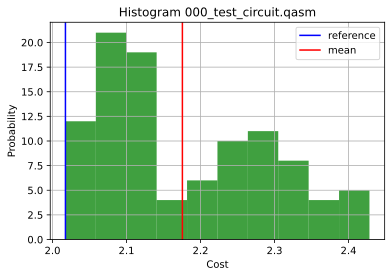

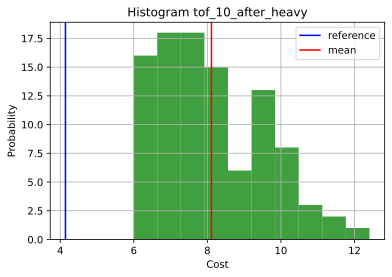

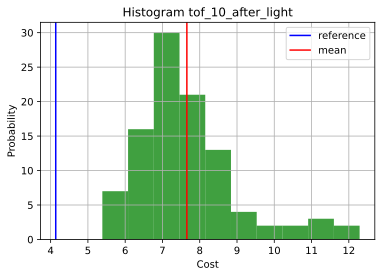

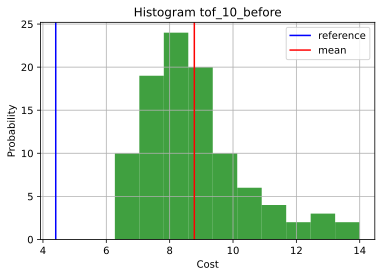

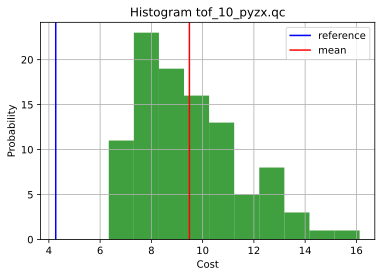

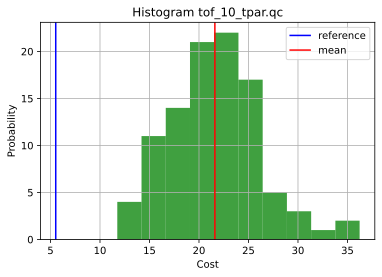

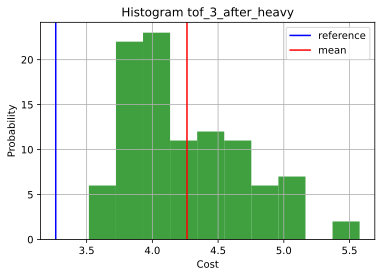

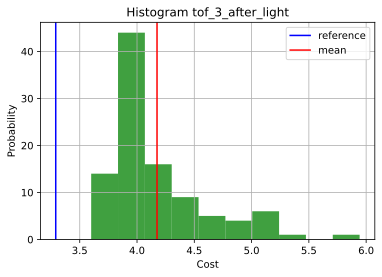

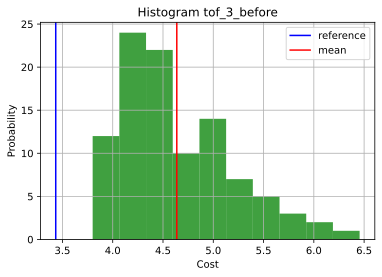

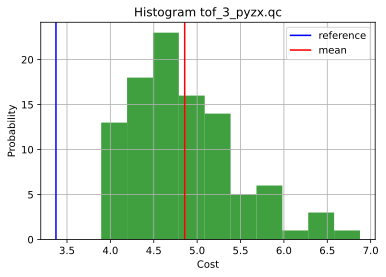

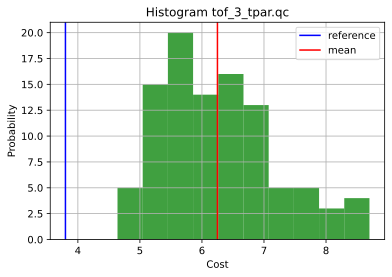

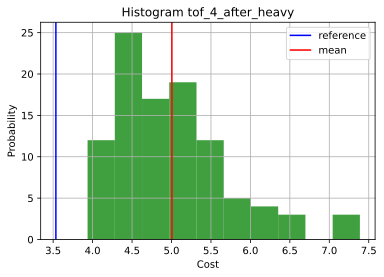

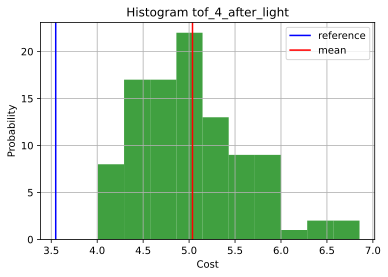

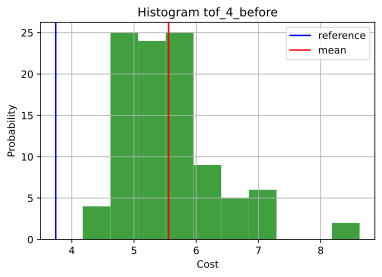

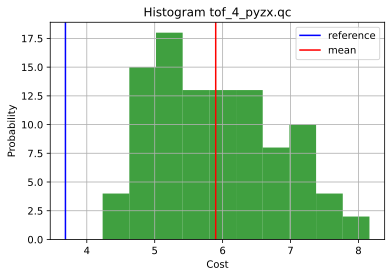

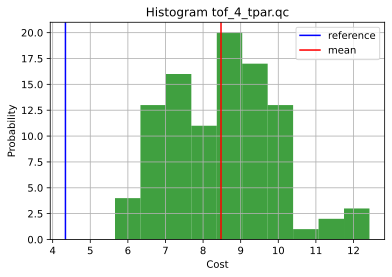

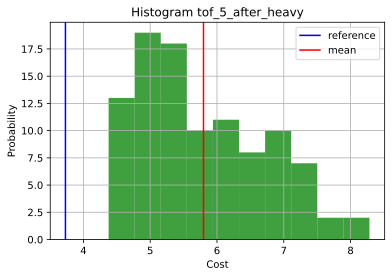

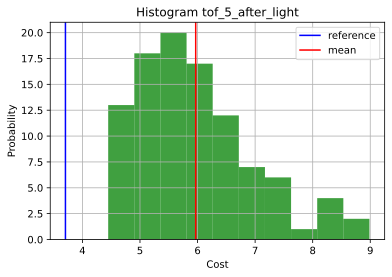

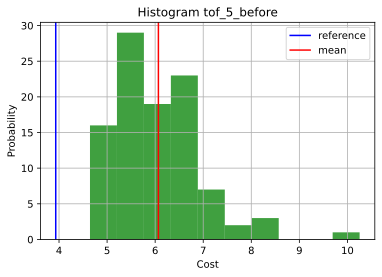

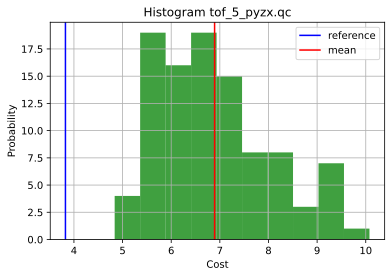

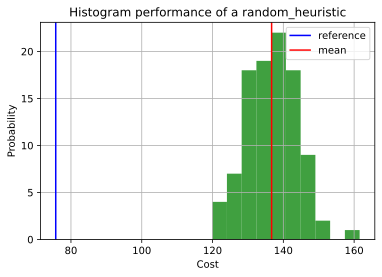

In [6]:
# Kind of a random heuristic:
nr_paths_samples = 100
importance_weights = [1, 0.5, 0.0]

contraction_costs_all = [0 for i in range(nr_paths_samples)]
reference_cost_all = 0
circuits_histograms = []
for name in tf:
    contraction_costs_random, cost_reference, _ = circuit_stats(name, nr_paths_samples, importance_weights)
    for i in range(nr_paths_samples):
        contraction_costs_all[i] = contraction_costs_all[i] + contraction_costs_random[i]
    reference_cost_all = reference_cost_all + cost_reference
    circuits_histograms.append(circuit_histogram(name, contraction_costs_random, cost_reference))

print("reference value:", reference_cost_all)
histogram_all = circuit_histogram("performance of a random_heuristic", contraction_costs_all, reference_cost_all)



In [7]:
# caramel\models\circuits_to_dataset\enhance_data_set_builder.py
# Create the pytorch data set
dataset = DualCircuitDataset(root='C:/Users/tomut/Documents/GitHub/caramel/circuit_dataset/dual_experiment_dataset/',
                             target_files=tf)

# Node features [nr_nodes,3]
# order  -> -1 for edges that are not and edges
#           or 'i' where 'i' is the position in the output_order
# node1 rank -> tensor 1 size
# node2 rank -> tensor 2 size

# Edge features [nr_edges, 2]
# node id
# node size


print("dataset:", dataset)
print("\n-Data extracted!- \n\n")

data = dataset[0]
print(data)


Processing...
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.87it/s]

dataset: CircuitDataset(20)

-Data extracted!- 


Data(
  x=[12, 3],
  edge_index=[2, 32],
  edge_attr=[32, 2],
  y={
    opt_einsum_input=[8],
    opt_einsum_output=[4],
    size_dict={
      9=2,
      6=1,
      0=2,
      10=1,
      2=2,
      5=2,
      4=2,
      1=2,
      11=2,
      3=1,
      7=2,
      8=1
    }
  }
)



Done!


In [8]:
# caramel\example_contraction_learning.py
# Model

class Model01(torch.nn.Module):
    def __init__(self, feature_size, model_params):
        super(Model01, self).__init__()

        ########################################################################
        ##   How to change the code bellow in order to have a good model ?    ##
        ########################################################################
        embedding_size = model_params["embedding_size"]
        n_heads = model_params["n_heads"]
        dropout_rate = model_params["dropout_rate"]
        edge_dim = model_params["edge_dim"]
        self.n_layers = model_params["model_layers"]

        # Transformation layer
        self.conv1 = TransformerConv(feature_size,
                                     embedding_size,
                                     heads=n_heads,
                                     dropout=dropout_rate,
                                     edge_dim=edge_dim,
                                     beta=True)
        self.transf1 = Linear(embedding_size * n_heads, embedding_size)
        self.bn1 = BatchNorm1d(embedding_size)

        # middle
        self.conv_layers = ModuleList([])
        self.transf_layers = ModuleList([])
        for i in range(self.n_layers):
            self.conv_layers.append(TransformerConv(embedding_size,
                                                    embedding_size,
                                                    heads=n_heads,
                                                    dropout=dropout_rate,
                                                    edge_dim=edge_dim,
                                                    beta=True))
            self.transf_layers.append(Linear(embedding_size * n_heads, embedding_size))

        self.conv2 = TransformerConv(embedding_size,
                                     1,
                                     heads=n_heads,
                                     dropout=dropout_rate,
                                     edge_dim=edge_dim,
                                     beta=True)
        self.transf2 = Linear(1 * n_heads, 1)
        self.bn2 = BatchNorm1d(1)

    def forward(self, x, edge_index, edge_attr):
        x = self.conv1(x, edge_index, edge_attr)
        x = self.transf1(x)
        x = self.bn1(x)

        for i in range(self.n_layers):
            x = self.conv_layers[i](x, edge_index, edge_attr)
            x = torch.relu(self.transf_layers[i](x))
            # print("i",i)

        x = self.conv2(x, edge_index, edge_attr)
        x = self.transf2(x)
        x = self.bn2(x)
        return x
    ########################################################################
    ##   How to change the code above in order to have a good model ?    ##
    ########################################################################



In [9]:
# Model hyperparametes 
params_model = {"embedding_size": 500,
                "n_heads": 4,
                "dropout_rate": 0.9,
                "edge_dim": 2,
                "model_layers": 4,
                }

model = Model01(feature_size=dataset[0].x.shape[1], model_params=params_model)
print("Model:", model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))


Model: Model01(
  (conv1): TransformerConv(3, 500, heads=4)
  (transf1): Linear(in_features=2000, out_features=500, bias=True)
  (bn1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_layers): ModuleList(
    (0): TransformerConv(500, 500, heads=4)
    (1): TransformerConv(500, 500, heads=4)
    (2): TransformerConv(500, 500, heads=4)
    (3): TransformerConv(500, 500, heads=4)
  )
  (transf_layers): ModuleList(
    (0): Linear(in_features=2000, out_features=500, bias=True)
    (1): Linear(in_features=2000, out_features=500, bias=True)
    (2): Linear(in_features=2000, out_features=500, bias=True)
    (3): Linear(in_features=2000, out_features=500, bias=True)
  )
  (conv2): TransformerConv(500, 1, heads=4)
  (transf2): Linear(in_features=4, out_features=1, bias=True)
  (bn2): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Number of parameters:  21125543


In [10]:
# Untrained model
model = model.to(device)
data = dataset[0].to(device)

prediction = model(data.x, data.edge_index, data.edge_attr)
print("prediction:", prediction)
print("prediction shape:", prediction.shape)

prediction: tensor([[ 0.3162],
        [-0.8929],
        [-0.1155],
        [ 1.7264],
        [-2.2582],
        [-0.6832],
        [ 0.0978],
        [-0.1433],
        [ 1.5564],
        [ 0.2818],
        [ 0.0110],
        [ 0.1036]], device='cuda:0', grad_fn=<NativeBatchNormBackward0>)
prediction shape: torch.Size([12, 1])


In [11]:

def contraction_loss(predictions, graphs_info, print_path=False):
    # path = predictions.reshape(predictions.shape[0])
    # print("predictions", predictions)
    # print("predictions shape", predictions.shape)
    predictions = predictions.reshape((1, predictions.shape[0]))
    contraction_cost_list = torch.tensor([[0.0]], dtype=torch.float32, requires_grad=True)
    for predicted_path in predictions:
        path = predicted_path
        path = edge_path_to_opt_einsum_path(path, graphs_info["opt_einsum_input"].copy())
        if print_path:
            print("\npath in opt_einsum format:", path)
        contraction_cost = cost_of_contraction(path, graphs_info, importance=importance_weights)
        contraction_cost_list = torch.cat([contraction_cost_list, torch.tensor([[contraction_cost]])], dim=1)

    ls = torch.sum(contraction_cost_list)

    return ls


###########Training##############


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:00<00:00,  6.02s/it]


[1] loss: 148.076
-Finished Training-
 


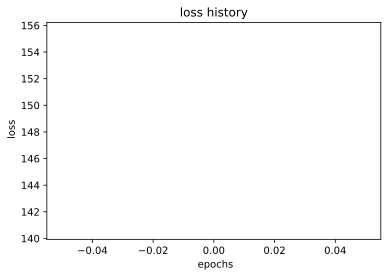

In [12]:

# Training
print("###########Training##############")
nr_epochs = 1
lr = 0.0005

model_optimizer = torch.optim.Adam(model.parameters(), lr)

loss_hist = []
for epoch in range(nr_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for data in tqdm(dataset):
        # get the inputs; data is a list of [inputs, labels]
        sample = data.to(device)

        # zero the parameter gradients
        model_optimizer.zero_grad()

        # forward + backward + optimize
        prediction = model(sample.x, sample.edge_index, sample.edge_attr)
        loss = contraction_loss(prediction, data.y)
        loss.backward()
        model_optimizer.step()

        # print statistics
        running_loss += loss.item()

    print(f'\n[{epoch + 1}] loss: {running_loss:.3f}')
    loss_hist.append(running_loss)

print('-Finished Training-\n ')

plt.plot(loss_hist)
plt.xlabel(' epochs')
plt.ylabel(' loss')
plt.title('loss history')
plt.savefig("figures/loss_history.png")
plt.show()
plt.close()


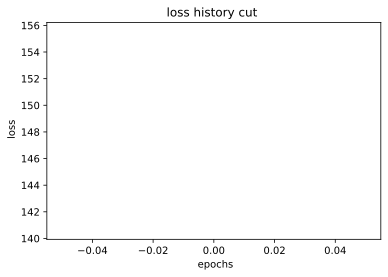

In [13]:
# Zoom on the last part of training
plt.plot(loss_hist[0:])
plt.xlabel(' epochs')
plt.ylabel(' loss')
plt.title('loss history cut ')
plt.savefig("figures/loss_history_cut.png")
plt.show()
plt.close()

In [14]:
# Model after training
data = dataset[0].to(device)
prediction = model(data.x, data.edge_index, data.edge_attr)
reshape_prediction = prediction.reshape((1, prediction.shape[0]))
print("prediction:", reshape_prediction)
loss = contraction_loss(prediction, data.y, print_path=True)
print("loss:", loss)


prediction: tensor([[ 0.9530,  0.3206,  0.0318,  0.3240,  0.5466,  0.3944,  0.3242, -0.0490,
         -3.1803,  0.2715,  0.2877, -0.2245]], device='cuda:0',
       grad_fn=<ReshapeAliasBackward0>)

path in opteinsum format: [(5, 6), (5, 6), (2, 4), (0, 2), (1, 2), (1, 2), (0, 1)]
loss: tensor(2.1209, dtype=torch.float64, grad_fn=<SumBackward0>)


In [ ]:
dataset[0].y